In [1]:
import pandas as pd
import os
from ast import literal_eval
import re

pd.set_option('display.max_columns', None)
os.chdir(r"C:\Users\LMENENDEZ\GitHub\MultiModX")
print(os.getcwd())
data_repository_path=r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2307_SESAR3_MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\CS11"

C:\Users\LMENENDEZ\GitHub\MultiModX


In [2]:
%load_ext autoreload

In [48]:
%autoreload
from script.trips_format import *
from strategic_evaluator.logit_model import *

In [4]:
pre_calibration_matrix=pd.read_csv(r".\pre_calibration_matrix_CS11.csv")

In [5]:
pre_calibration_matrix.head()

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air,option_number,total_time_air,cost_ground,total_time_ground,emissions_ground,number_of_options_per_od
0,ES111,BRUSSELS,access,"['LEST', 'BRUSSELS']",43.0,50.443667,134.69,1559.5,1,104,0.0,53.0,0.0,2
1,ES111,BRUSSELS,access,"['LEST', 'LEMD', 'BRUSSELS']",11.0,12.087667,134.69,1559.5,2,224,0.0,53.0,0.0,2
2,ES111,EDDM,access,"['LEST', 'EDDM']",15.0,15.474000,213.24,1830.0,1,122,0.0,53.0,0.0,2
3,ES111,EDDM,access,"['LEST', 'LEMD', 'EDDM']",10.0,12.387667,213.24,1830.0,2,242,0.0,53.0,0.0,2
4,ES111,EHAM,access,"['LEST', 'EHAM']",46.0,50.568667,180.87,1691.0,1,113,0.0,53.0,0.0,4


before formatting, I will update the data for total time air and emissions air using itineraries calculated by the pipeline with no rail layer

In [6]:
air_paths_costs=pd.read_csv(data_repository_path+r"\v=0.25\output\processed_cs11.pp00.no_rail_c2\paths_itineraries\possible_paths_avg_from_filtered_it_0.csv")

In [7]:
aw_paths=pd.read_csv(data_repository_path+r"\aw\aw_paths_costs.csv")

In [8]:
# create an airport to city airport for international cities with more than 2 airports
dict_1=dict(zip(aw_paths[aw_paths["origin"]!=aw_paths["origin_city"]]["origin"],aw_paths[aw_paths["origin"]!=aw_paths["origin_city"]]["origin_city"]))
dict_2=dict(zip(aw_paths[aw_paths["destination"]!=aw_paths["destination_city"]]["destination"],aw_paths[aw_paths["destination"]!=aw_paths["destination_city"]]["destination_city"]))
airport_to_city=dict_1 | dict_2

In [9]:
print(f"before groupby there were {air_paths_costs.shape[0]} rows")
air_paths_costs["path_list"]=air_paths_costs["path"].apply(literal_eval)
# changes the first element of the path
air_paths_costs["path_list"]=air_paths_costs["path_list"].apply(lambda lst: [airport_to_city[lst[0]]]+ lst[1:] if lst and lst[0] in airport_to_city.keys() else lst)
# changes the last element of the path
air_paths_costs["path_list"]=air_paths_costs["path_list"].apply(lambda lst: lst[:-1]+[airport_to_city[lst[-1]]] if lst and lst[-1] in airport_to_city.keys() else lst)
# change the path
air_paths_costs["path"]=air_paths_costs["path_list"].astype(str)
air_paths_costs=air_paths_costs.groupby(by=["origin","destination","path"]).agg({
    "total_avg_travel_time":"mean",
    "total_avg_cost":"mean",
    "total_avg_emissions":"mean"
    }
).reset_index()
print(f"after groupby there were {air_paths_costs.shape[0]} rows")

before groupby there were 1546 rows
after groupby there were 1366 rows


In [10]:
air_paths_costs.sample(2)

,origin,destination,path,total_avg_travel_time,total_avg_cost,total_avg_emissions
1047,LEZL,LFBD,"['LEZL', 'LEMD', 'LFBD']",291.666667,268.37,124.963333
502,LEBL,DUESSELDORF,"['LEBL', 'DUESSELDORF']",173.750000,185.62,75.835000


In [11]:
pre_calibration_matrix.sample(2)

,origin,destination,node_sequence_ground,node_sequence_air,trips,trips_air,cost_air,distance_air,option_number,total_time_air,cost_ground,total_time_ground,emissions_ground,number_of_options_per_od
1622,MILAN,ES521,egress,"['MILAN', 'LEVC']",22.0,474.599333,86.437303,1054.817724,2,70,0.0,144.0,0.0,3
440,ES612,EKCH,access,"['LEMG', 'EKCH']",17.0,677.292333,122.350000,2472.000000,1,165,0.0,171.0,0.0,2


In [12]:
print(f"before the merge there were {pre_calibration_matrix.shape[0]} rows and {pre_calibration_matrix["trips"].sum()} trips")
pre_calibration_matrix=pd.merge(left=pre_calibration_matrix,
                                right=air_paths_costs,
                                left_on=["node_sequence_air"],
                                right_on=["path"],
                                how="inner")
print(f"after the merge there are {pre_calibration_matrix.shape[0]} rows and {pre_calibration_matrix["trips"].sum()} trips")

before the merge there were 2387 rows and 159708.0 trips
after the merge there are 1829 rows and 148263.0 trips


In [13]:
pre_calibration_matrix=pre_calibration_matrix.drop(columns=["origin_y","destination_y"])
pre_calibration_matrix["total_time_air"]=pre_calibration_matrix["total_avg_travel_time"]
pre_calibration_matrix["cost_air"]=pre_calibration_matrix["total_avg_cost"]
pre_calibration_matrix=pre_calibration_matrix.rename(columns={"total_avg_emissions":"emissions_air",
                                       "origin_x":"origin",
                                       "destination_x":"destination"
                                       })
pre_calibration_matrix=pre_calibration_matrix.drop(columns=["total_avg_travel_time","total_avg_cost"])

Some trips are lost in the merge, but that is fine I guess

In [14]:
pre_calibration_matrix[pre_calibration_matrix["number_of_options_per_od"]<=3]["trips"].sum()

np.float64(137570.0)

In [15]:
pre_calibration_matrix[pre_calibration_matrix["number_of_options_per_od"]>3]["trips"].sum()

np.float64(10693.0)

Since most trips have 3 options or less, I will stay with only these

In [16]:
def preformat_trips_logit(trips):
    # calculate quantities that will be used for calibration
    trips["total_travel_time"]=trips["total_time_air"]+trips["total_time_ground"]
    trips["total_cost"]=trips["cost_air"]+trips["cost_ground"]
    trips["total_emissions"]=trips["emissions_ground"]+trips["emissions_air"] #ADD EMISSIONS AIR WHEN I HAVE THEM
    
    # construct path for trips whose node_sequence_ground is only access or egress
    trips.loc[trips["node_sequence_ground"].isin(["access","egress"]),"path"]=trips["node_sequence_air"]

    # filter for trips leaving spain and having non-trivial ground sequence
    filter_leaving=~(trips["node_sequence_ground"].isin(["access","egress"]))& trips["origin"].str.startswith("ES") & trips["origin"].str[2].str.isdigit()
    trips.loc[filter_leaving,"path_list"]=trips.loc[filter_leaving,"node_sequence_ground"].apply(ast.literal_eval) + trips.loc[filter_leaving,"node_sequence_air"].apply(ast.literal_eval)
    
    # filter for trips incoming with non-trivial ground sequence
    filter_incoming=~(trips["node_sequence_ground"].isin(["access","egress"]))& trips["destination"].str.startswith("ES") & trips["destination"].str[2].str.isdigit()
    trips.loc[filter_incoming,"path_list"]=trips.loc[filter_incoming,"node_sequence_air"].apply(ast.literal_eval) + trips.loc[filter_incoming,"node_sequence_ground"].apply(ast.literal_eval)

    # filter all trips with only access or egress as ground sequence
    condition=~(trips["node_sequence_ground"].isin(["access", "egress"]))
    trips.loc[condition, "path"] = trips.loc[condition,"path_list"].apply(str)
    
    #drop useless columns
    trips=trips.drop(columns=["trips_air","option_number","number_of_options_per_od","total_time_ground","total_time_air","emissions_ground","emissions_air","cost_air","cost_ground","distance_air","node_sequence_ground","node_sequence_air","path_list"])
    return trips

In [17]:
trips_logit=preformat_trips_logit(pre_calibration_matrix)

In [18]:
trips_logit.head(3)

,origin,destination,trips,path,total_travel_time,total_cost,total_emissions
0,ES111,BRUSSELS,11.0,"['LEST', 'LEMD', 'BRUSSELS']",355.0,329.65,146.532
1,ES111,EDDM,10.0,"['LEST', 'LEMD', 'EDDM']",346.0,338.61,151.576
2,ES111,EHAM,14.0,"['LECO', 'LEMD', 'EHAM']",330.0,339.09,131.420


In [19]:
def add_pax_processes(trips):

    incoming_trips_pattern=trips["origin"].str.isalpha()
    train_station_pattern=trips["path"].str.contains(r"\d",regex=True)
    # +30 minutes for passengers exiting the airport 
    trips[incoming_trips_pattern]["total_travel_time"]+=30
    # +15 minutes to transfer from airport to a train station
    trips[(incoming_trips_pattern)&train_station_pattern]["total_travel_time"]+=15
    # +90 minutes for passengers going to an airport 
    trips[~incoming_trips_pattern]["total_travel_time"]+=90
    # +10 minutes for passengers leaving a train station
    trips[(~incoming_trips_pattern)&train_station_pattern]["total_travel_time"]+=10
    return trips


In [20]:
trips_logit=add_pax_processes(trips_logit)

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_12132\5192576.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trips[incoming_trips_pattern]["total_travel_time"]+=30
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_12132\5192576.py:6: Sett

In [21]:
trips_logit.sample(5)

,origin,destination,trips,path,total_travel_time,total_cost,total_emissions
238,ES511,EVRA,130.0,"['LEBL', 'EVRA']",255.5,236.530,144.935000
1405,OMAA,ES425,1.0,"['OMAA', 'LEMD', '007160000', '007192102']",588.0,327.740,620.870000
393,ES613,MILAN,9.0,"['LEMG', 'MILAN']",321.0,203.285,92.713333
113,ES611,EHRD,1.0,"['LEAL', 'EHRD']",364.0,205.730,94.040000
327,ES612,EGPH,12.0,"['LEMG', 'EGPH']",373.5,229.520,126.110000


In [22]:
trips_logit[trips_logit["path"].notna()]

,origin,destination,trips,path,total_travel_time,total_cost,total_emissions
0,ES111,BRUSSELS,11.0,"['LEST', 'LEMD', 'BRUSSELS']",355.000000,329.65,146.532000
1,ES111,EDDM,10.0,"['LEST', 'LEMD', 'EDDM']",346.000000,338.61,151.576000
2,ES111,EHAM,14.0,"['LECO', 'LEMD', 'EHAM']",330.000000,339.09,131.420000
3,ES111,EHAM,11.0,"['LEST', 'LEMD', 'EHAM']",339.666667,336.75,137.666667
4,ES111,EHAM,4.0,"['LEVX', 'LEMD', 'EHAM']",403.000000,334.85,143.948000
...,...,...,...,...,...,...,...
1824,ES243,VENICE,1.0,"['007104040', '007171801', 'LEBL', 'VENICE']",354.522727,196.53,72.247500
1825,ES211,EDDK,12.0,"['LEVT', 'EDDK']",141.000000,185.17,73.110000
1826,ES211,LPPR,3.0,"['LEBB', 'LPPR']",131.000000,140.55,46.110000
1827,ES211,MILAN,12.0,"['LEBB', 'MILAN']",196.000000,173.01,67.010000


In [23]:
trips_logit[trips_logit["path"].isna()]

,origin,destination,trips,path,total_travel_time,total_cost,total_emissions


In [24]:
trips_logit_formatted=trips_logit_format(trips_logit=trips_logit,
                                         max_num_options=3,
                                         drop_single_paths=True,
                                         n_archetypes=1
                                         )

In [25]:
paths_w_costs=generate_paths_w_costs(trips_logit=trips_logit_formatted,
                                     max_num_option=3
                                     )

In [26]:
paths_w_costs.sample(5)

,origin,destination,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3
383,ES300,LFLL,139.250000,170.12,84.395000,0,1,0,1,344.000000,210.39,87.380,0,0,1,1,345.922414,195.45,65.28,0,0,1,1
1059,ISTANBUL,ES425,447.500000,249.60,400.630000,0,1,0,1,485.500000,255.75,402.550,0,0,1,1,-1.000000,-1.00,-1.00,0,0,0,0
100,EDDM,ES521,195.333333,202.38,94.086667,0,1,0,1,284.000000,197.10,84.090,0,1,0,1,-1.000000,-1.00,-1.00,0,0,0,0
1396,OEJN,ES413,636.500000,323.95,550.130000,0,0,1,1,644.000000,297.62,541.880,0,1,0,1,-1.000000,-1.00,-1.00,0,0,0,0
1299,LROP,ES617,275.000000,248.91,398.740000,0,1,0,1,516.083333,284.58,159.434,0,0,1,1,-1.000000,-1.00,-1.00,0,0,0,0


In [27]:
trips_logit_formatted[(trips_logit_formatted["origin"]=="EGGD")&(trips_logit_formatted["destination"]=="ES514")]

,origin,destination,trips,path,total_travel_time,total_cost,total_emissions,noption,trips_per_od_pair,prob_per_od_pair_arch_0
163,EGGD,ES514,12.0,"['EGGD', 'LEBL']",198.500000,186.23,82.475,1,13.0,0.923077
164,EGGD,ES514,1.0,"['EGGD', 'LEBL', '007171801', '007165402']",375.730769,199.72,86.695,2,13.0,0.076923


In [28]:
calibration_matrix=generate_calibration_matrix(trips_logit=trips_logit_formatted,
                            paths_w_costs=paths_w_costs,
                            drop_single_paths=True)

In [29]:
calibration_matrix[calibration_matrix["train_2"]!=0]

,trips,total_travel_time,observed_choice,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3


In [30]:
calibration_matrix[calibration_matrix["train_3"]!=0]

,trips,total_travel_time,observed_choice,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3


In this case, there are no trips with rail. So we have to change the way we calibrate the model, perhaps using a dictionary?

In [31]:
calibration_matrix.to_csv("calibration_matrix_CS11_v0.2.csv")

In [32]:
# Delete pickle files if they already exist 
pickle_file="trips.pickle"
if os.path.exists(pickle_file):
    os.remove(pickle_file)
    print(f"Deleted {pickle_file}")
else: 
    print(f"pickle file {pickle_file} doesn't exist")


Deleted trips.pickle


In [33]:
# we do not need to change the calibration matrix
database_path=r".\calibration_matrix_CS11_v0.2.csv"
test_results=calibrate_main(database_path=database_path,
                            n_archetypes=1,
                            n_alternatives=3)

The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 0[3.0]-1[3.0]-2[3.0]-3[3.0]-4[3.0]-5[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-11[3.0]-13[3.0]-14[3.0]-15[3.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 0[3.0]-1[3.0]-2[3.0]-3[3.0]-4[3.0]-5[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-11[3.0]-13[3.0]-14[3.0]-15[3.0...


Training results:
Results for model trips
Nbr of parameters:		3
Sample size:			1226
Excluded data:			0
Final log likelihood:		-189.4097
Akaike Information Criterion:	384.8193
Bayesian Information Criterion:	400.1539

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.254677      0.397401     3.157210      0.001593
B_COST     0.007778      0.006417     1.212062      0.225489
B_TIME    -0.024173      0.001959   -12.342270      0.000000
{'ASC_PLANE': np.float64(1.254677280769151), 'B_COST': np.float64(0.007777636372390648), 'B_TIME': np.float64(-0.02417304766695015)}
Test results:
{'ASC_PLANE': np.float64(1.254677280769151), 'B_COST': np.float64(0.007777636372390648), 'B_TIME': np.float64(-0.02417304766695015)}
        prob_1    prob_2  prob_3
1513  0.995653  0.004347     0.0
468   0.897573  0.102427     0.0
378   0.999299  0.000701     0.0
860   0.999780  0.000220     0.0
996   0.728265  0.271735     0.0
...        ...       ...     ...
1288  0.995653  0.004347    

In [34]:
test_results

{'test_results':         prob_1    prob_2  prob_3
 1513  0.995653  0.004347     0.0
 468   0.897573  0.102427     0.0
 378   0.999299  0.000701     0.0
 860   0.999780  0.000220     0.0
 996   0.728265  0.271735     0.0
 ...        ...       ...     ...
 1288  0.995653  0.004347     0.0
 179   0.999952  0.000048     0.0
 876   0.999477  0.000523     0.0
 713   0.903660  0.096340     0.0
 342   0.240076  0.759924     0.0
 
 [307 rows x 3 columns]}

In [35]:
archetypes={}
archetypes["archetype_0"]=res.bioResults(pickle_file="trips.pickle")

In [41]:
archetypes["archetype_0"].get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_PLANE,1.254677,0.397401,3.157210,0.001593
B_COST,0.007778,0.006417,1.212062,0.225489
B_TIME,-0.024173,0.001959,-12.342270,0.000000


In [42]:
def calibration_results_summary_one_arch(archetypes: dict):
    data=[]
    
    archetype = archetypes["archetype_0"] # accesses the values  
    values=archetype.get_estimated_parameters() # dataframe of the betavalues 
    
    asc_plane = values.loc['ASC_PLANE']["Value"]  
    asc_plane_significance=(values.loc["ASC_PLANE"]["Rob. p-value"]<0.05)

    #asc_train = values.loc['ASC_TRAIN']["Value"]
    #asc_train_significance=(values.loc["ASC_TRAIN"]["Rob. p-value"]<0.05)

    if "B_CO2" in values.index:
        b_co2 = values.loc['B_CO2']["Value"]      
        b_co2_significance=(values.loc["B_CO2"]["Rob. p-value"]<0.05)
    else:
        b_co2="Not calibrated"
        b_co2_significance="NA"

    b_time = values.loc['B_TIME']["Value"]
    b_time_significance=(values.loc["B_TIME"]["Rob. p-value"]<0.05)

    b_cost=values.loc["B_COST"]["Value"]
    b_cost_significance=(values.loc["B_COST"]["Rob. p-value"]<0.05)

    # Create a row dictionary
    row = {
        "Archetype": "Archetype_0",
        "ASC_PLANE": asc_plane,
        "ASC_PLANE_SIGNIFICANCE": asc_plane_significance,
        #"ASC_TRAIN": asc_train,
        #"ASC_TRAIN_SIGNIFICANCE": asc_train_significance,
        "B_CO2": b_co2,
        "B_CO2_SIGNIFICANCE": b_co2_significance,
        "B_TIME": b_time,
        "B_TIME_SIGNIFICANCE": b_time_significance,
        "B_COST": b_cost,
        "B_COST_SIGNIFICANCE": b_cost_significance
    }
    
    # Append the row to the list
    data.append(row)

    calibration_results = pd.DataFrame(data)
    return calibration_results

In [43]:
calibration_results_summary_one_arch(archetypes=archetypes)

,Archetype,ASC_PLANE,ASC_PLANE_SIGNIFICANCE,B_CO2,B_CO2_SIGNIFICANCE,B_TIME,B_TIME_SIGNIFICANCE,B_COST,B_COST_SIGNIFICANCE
0,Archetype_0,1.254677,True,Not calibrated,NA,-0.024173,True,0.007778,False


In [44]:
final_test=test_logit(test_results,trips_logit_formatted, n_alternatives=1)

In [45]:
final_test

{'archetype_0':      location prob_predicted prob_observed
 0        1513       0.995653      0.833333
 1         468       0.102427      0.166667
 2         378       0.999299      0.996599
 3         860        0.00022           0.2
 4         996       0.728265      0.697674
 ..        ...            ...           ...
 302      1288       0.004347      0.086957
 303       179       0.000048      0.008403
 304       876       0.000523           0.5
 305       713        0.09634      0.090909
 306       342       0.759924          0.24
 
 [307 rows x 3 columns]}

In [46]:
evaluate_model(test_data=final_test["archetype_0"],model_name="international")

international Evaluation:
Mean Squared Error: 0.0364
Mean Absolute Error: 0.1259
Pearson Correlation: 0.8786
Spearman Correlation: 0.8841
Standard deviation: 0.1909


(np.float64(0.03644127286300786),
 np.float64(0.12586435572091254),
 np.float64(0.8785710901056668),
 np.float64(0.884125727994251),
 np.float64(0.19089561506123576))

0 rows were removed


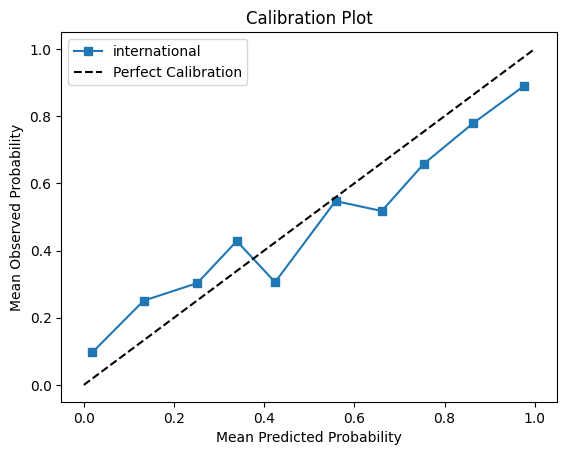

In [47]:
calibration_plot(test_data=final_test["archetype_0"],model_name="international")

We see that the model without CO2 performs quite well. Now let us add CO2 into account

In [49]:
# Delete pickle files if they already exist 
pickle_file="trips.pickle"
if os.path.exists(pickle_file):
    os.remove(pickle_file)
    print(f"Deleted {pickle_file}")
else: 
    print(f"pickle file {pickle_file} doesn't exist")

Deleted trips.pickle


In [55]:
database_path=r".\calibration_matrix_CS11_v0.2.csv"
test_results_co2=calibrate_main(database_path=database_path,
                            n_archetypes=1,
                            n_alternatives=3)

The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 0[3.0]-1[3.0]-2[3.0]-3[3.0]-4[3.0]-5[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-11[3.0]-13[3.0]-14[3.0]-15[3.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 0[3.0]-1[3.0]-2[3.0]-3[3.0]-4[3.0]-5[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-11[3.0]-13[3.0]-14[3.0]-15[3.0...


Training results:
Results for model trips
Nbr of parameters:		4
Sample size:			1226
Excluded data:			0
Final log likelihood:		-188.5449
Akaike Information Criterion:	385.0899
Bayesian Information Criterion:	405.5359

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.285171      0.399950     3.213328      0.001312
B_CO2      0.007030      0.005279     1.331771      0.182935
B_COST     0.010546      0.005467     1.929192      0.053707
B_TIME    -0.024294      0.001980   -12.268526      0.000000
{'ASC_PLANE': np.float64(1.2851714964920398), 'B_CO2': np.float64(0.0070304367852370075), 'B_COST': np.float64(0.010545943475256664), 'B_TIME': np.float64(-0.024293696361499577)}
Test results:
{'ASC_PLANE': np.float64(1.2851714964920398), 'B_CO2': np.float64(0.0070304367852370075), 'B_COST': np.float64(0.010545943475256664), 'B_TIME': np.float64(-0.024293696361499577)}
        prob_1    prob_2  prob_3
1513  0.995587  0.004413     0.0
468   0.898012  0.101988     0.0
378   0

In [56]:
archetypes_co2={}
archetypes_co2["archetype_0"]=res.bioResults(pickle_file="trips.pickle")

In [57]:
calibration_results_summary_one_arch(archetypes=archetypes_co2)

,Archetype,ASC_PLANE,ASC_PLANE_SIGNIFICANCE,B_CO2,B_CO2_SIGNIFICANCE,B_TIME,B_TIME_SIGNIFICANCE,B_COST,B_COST_SIGNIFICANCE
0,Archetype_0,1.285171,True,0.00703,False,-0.024294,True,0.010546,False


In [58]:
final_test_co2=test_logit(test_results_co2,trips_logit_formatted, n_alternatives=1)

In [61]:
evaluate_model(test_data=final_test_co2["archetype_0"],model_name="international with co2")

international with co2 Evaluation:
Mean Squared Error: 0.0362
Mean Absolute Error: 0.1249
Pearson Correlation: 0.8796
Spearman Correlation: 0.8848
Standard deviation: 0.1904


(np.float64(0.036246703577326976),
 np.float64(0.12485465023362939),
 np.float64(0.8795552995632356),
 np.float64(0.8847938208690893),
 np.float64(0.1903856623134967))

0 rows were removed


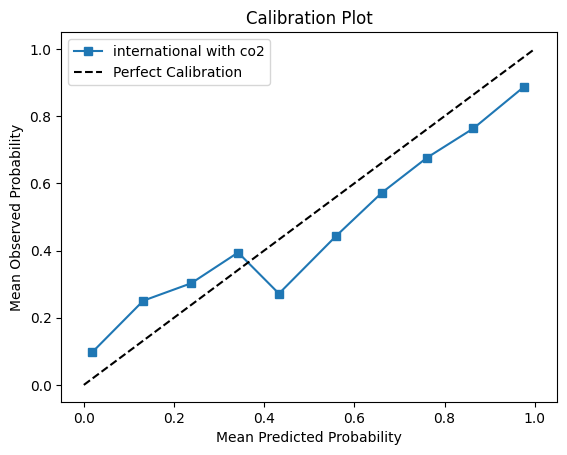

In [62]:
calibration_plot(test_data=final_test_co2["archetype_0"],model_name="international with co2")

Adding CO2 doesn't change how the model performs, hence the best calibration is the one without it